# Accuracy versus energy
Goals=Compare energy consumed versus learning advancement.

No information on training accuracy, only evaluations.

ToDo:
- compute total energy timeserie
- plot in parallel with accuracy
- compute energy between each eval

In [13]:
import pandas as pd
# import modin.pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

logs = # TO FILL
graph_dir = f"{logs}/graphs/accuracy"
processed_log_dir = f"{logs}/resultats_11-23_processed"
save_dir = f"{processed_log_dir}/bert"
log_dir = f"{logs}/resultats_11-23/bert/"

job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"

job = 126224

# 20 secondes
# energy = dd.read_csv(
#     energy_file, 
#     dtype={'cpu': 'object', 'socket': 'object', 'domain': 'object'}).drop(columns=["Unnamed: 0"])
# energy.to_parquet(save_dir+'energy.parquet', engine='pyarrow')
energy = dd.read_parquet(save_dir+'/energy.parquet', engine='pyarrow')
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])


In [14]:
plot_df = jobs[(jobs["job"]==job)]

In [15]:
file = plot_df.file.values[0]
file.split("/")[-2:]

['126224', '231106120404308894939_1.log']

In [16]:
import sys
sys.path.append("../../../logging/mlperf_logging/")
from compliance_checker.mlp_parser import parse_file


log_file = log_dir + "/".join(file.split("/")[-2:])
print(log_file)

loglines, _ = parse_file(log_file, ruleset="2.1.0")
mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

/Users/mathildepro/Documents/code_projects/logs/Apollo/resultats_11-23/bert/126224/231106120404308894939_1.log


In [17]:
mllog = mllog.drop(['metadata.file', 'metadata.lineno', 'metadata.tensor', 'metadata.status'], axis=1)

In [18]:
pd.set_option('display.max_colwidth', 15)
pd.set_option('display.max_rows', 67)
table = mllog[mllog["value"].notna()].dropna(axis=1,how='all')
cols = [x for x in table.columns] # if (x != "full_string") and (x != "metadata")]
table[cols].style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

,value,metadata.epoch_num,timestamp,key
8,bert,nan,1699268707917.000000,submission_benchmark
9,SUBMISSION_ORG_PLACEHOLDER,nan,1699268707917.000000,submission_org
10,closed,nan,1699268707917.000000,submission_division
11,onprem,nan,1699268707917.000000,submission_status
12,1xSUBMISSION_PLATFORM_PLACEHOLDER,nan,1699268707917.000000,submission_platform
13,51,nan,1699268707917.000000,seed
14,384,nan,1699268707917.000000,global_batch_size
15,48,nan,1699268707917.000000,d_batch_size
16,1,nan,1699268707917.000000,gradient_accumulation_steps
17,76,nan,1699268707917.000000,max_predictions_per_seq


In [19]:
l = mllog[mllog["key"]=="init_start"]["timestamp"].values
l[0] - l[7]

-198.0

In [20]:
mllog["key"].unique()   

array(['init_start', 'submission_benchmark', 'submission_org',
       'submission_division', 'submission_status', 'submission_platform',
       'seed', 'global_batch_size', 'd_batch_size',
       'gradient_accumulation_steps', 'max_predictions_per_seq',
       'opt_learning_rate_training_steps', 'num_warmup_steps',
       'weights_initialization', 'opt_base_learning_rate',
       'opt_lamb_epsilon', 'opt_lamb_beta_1', 'opt_lamb_beta_2',
       'opt_lamb_weight_decay_rate', 'opt_learning_rate_warmup_steps',
       'opt_lamb_learning_rate_decay_poly_power', 'start_warmup_step',
       'init_stop', 'run_start', 'epoch_start', 'block_start',
       'data_file', 'block_stop', 'eval_accuracy', 'epoch_stop',
       'train_samples', 'eval_samples', 'run_stop'], dtype=object)

In [21]:
# import itertools
# import numpy as np
# keys = ['eval_accuracy', 'eval_samples', 'global_batch_size',
#        'gradient_accumulation_steps', 'init_start', 'init_stop',
#        'run_start', 'run_stop', 
#        'submission_benchmark', #'submission_division', 'submission_org', 'submission_platform','submission_status', 
#        'train_samples', 'weights_initialization']

# fig, ax = plt.subplots(figsize=(20,10))
# ax2 = ax.twinx()
# energy[energy["job"]==job].sort_values(by="timestamp").groupby("timestamp")[["energy_consumption_since_previous_measurement_milliJ"]].sum().compute().plot(ax=ax,y="energy_consumption_since_previous_measurement_milliJ", color="blue", alpha=0.5)
# ax.set_ylabel("Power (kW)")

# COLOR = plt.cm.tab10
# iter = itertools.cycle(COLOR(np.linspace(0, 1, len(keys))))
# ymin = 1.5e6
# size = 3e5
# for key in keys:
#     color = next(iter)
#     ax.vlines(x=mllog[mllog["key"]==key]["timestamp"], ymin=ymin, ymax=ymin+size, color=color, linewidth=3, label=key)
#     # ymin+=size

# ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)

# ax.vlines(x=jobs[jobs["job"]==job]["start_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")
# ax.vlines(x=jobs[jobs["job"]==job]["end_time_ms"], ymin=0, ymax=size, color="red", linewidth=3, label="Accuracy")

# mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].plot(ax=ax2,x="timestamp", y="value", label="Accuracy", color="orange", linewidth=3)
# ax2.set_ylabel("Accuracy")



# For all jobs

In [23]:
def compute_energy_between_accuracies(row):
        """Compute energy between two accuracy values."""
        mask = (energy["timestamp"]>=row["timestamp"]-row["time_diff"])&(energy["timestamp"]<=row["timestamp"])
        energy_between_accuracies = energy[mask]["energy_kWh"].sum().compute()
        return energy_between_accuracies

accuracy_df = pd.DataFrame()

for job in jobs["job"].unique():
    file = jobs[jobs["job"]==job]["file"].values[0]
    file.split("/")[-2:]    
    log_file = log_dir + "/".join(file.split("/")[-2:])

    loglines, _ = parse_file(log_file, ruleset="2.1.0")
    mllog = pd.json_normalize(pd.DataFrame(loglines)["value"])
    mllog = mllog.merge(pd.DataFrame(loglines)[["timestamp", "key"]], left_index=True, right_index=True)

    acc_df = mllog[mllog["key"]=="eval_accuracy"][["timestamp", "value"]].reset_index(drop=True)
    acc_df["time_diff"] = acc_df["timestamp"].diff()
    acc_df["acc_diff"] = acc_df["value"].diff()
    acc_df.rename(columns={"value":"accuracy"}, inplace=True)
    acc_df.at[0, "acc_diff"] = acc_df.at[0, "accuracy"]
    first_timestamp = acc_df.at[0, "timestamp"]
    run_start = mllog[mllog["key"]=='run_start']["timestamp"].values[0]
    acc_df.at[0, "time_diff"] = first_timestamp - run_start
    acc_df["energy_kWh"] = acc_df.apply(compute_energy_between_accuracies, axis=1)
    acc_df["energy_kWh_cumsum"] = acc_df["energy_kWh"].cumsum()
    acc_df.loc[len(acc_df)] = None
    acc_df = acc_df.shift(1).fillna(0)
    acc_df["job"] = job
    
    accuracy_df = pd.concat([accuracy_df, acc_df])


In [24]:
accuracy_df.job.unique()

array([126224, 126225, 126226, 126227, 126228, 126229, 126230, 126231,
       126232, 126233, 126234, 126235, 126236, 126237, 126238, 126239,
       126240, 126241, 126242, 126243, 126244, 126245, 126246, 126737,
       126738, 126739, 126740])

In [25]:
accuracy_job = accuracy_df.merge(jobs, on="job", how="left")

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

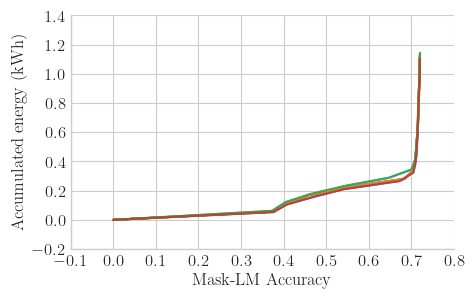

In [27]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="accuracy", y="energy_kWh_cumsum",
    data=accuracy_job[(accuracy_job["mllog_gradient_accumulation_steps"]==1)&(accuracy_job["node_nb"]==1)], 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set_xlabels("Mask-LM Accuracy", fontsize=FONTSIZE)
ax.set_ylabels("Accumulated energy (kWh)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
ax.savefig(f"{graph_dir}/bert.pdf", dpi=300)